## Лабораторная 1. Создание PoS-теггера

#### Петрова Мария, Цендякова Светлана.  15 фпл

#### Типология латвийского языка

In [5]:
from conllu import parse_incr
import numpy as np
import matplotlib.pyplot as plt
import statistics as s

from keras.layers.core import Activation, Dense
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU
from keras.layers.wrappers import TimeDistributed
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.utils import np_utils
from sklearn.model_selection import train_test_split


### Дескриптивная статистика для тренировочной и тестовой выборки

In [6]:
def parse(file,sentences,tags): #не забыть передать функции пустые контейнеры для тэгов и предложений
    data = open(file,'r',encoding='utf-8')
    for tokenlist in parse_incr(data): #tokenlist - это токены одного предложения
        #print(tokenlist)
        sentence = []
        for token in tokenlist:
            sentence.append(token['form'].lower()) #берем форму слова в нижнем регистре
            tags.append(token['upostag']) #берем тэг части речи
        sentences.append(sentence) #собираем список списков
    
    return sentences,tags    

In [4]:
def tag_distribution(tags): #функция, которая считает распределение тэгов, нужно будет чуть позже для графика
    distribution = {}
    for tag in tags:
        if tag not in distribution.keys():
            distribution[tag]=tags.count(tag)            
    return distribution

##### Распарсим файл и получим нужные нам данные из тренировочной выборки - уникальные теги и список предложений

In [10]:
file = 'lv_lvtb-ud-train.conllu'
latvian_train_sentences = []
latvian_train_tags = []
parse(file,latvian_train_sentences,latvian_train_tags)
latvian_train_tag_distribution = tag_distribution(latvian_train_tags)
latvian_train_tags = set(latvian_train_tags) #отберем только уникальные
len_train_sent = len(latvian_train_sentences) #количество предложений

##### Распарсим файл и получим нужные нам данные из тестовой выборки - уникальные теги и список предложений

In [9]:
file = 'lv_lvtb-ud-test.conllu'
latvian_test_sentences = []
latvian_test_tags = []
test_sentences = parse(file,latvian_test_sentences,latvian_test_tags)
latvian_test_tag_distribution = tag_distribution(latvian_test_tags)

latvian_test_tags = set(latvian_test_tags) #отберем только уникальные
len_test_sent = len(latvian_test_sentences) #количество предложений

#### Собираем статистику: 
Число предложений / уникальных словоформ;
Число уникальных PoS-тегов;
Максимальное и минимальное число слов в предложении;
Математическое ожидание и медиана числа слов в предложении;
Доля новых (не встречавшихся в тренировочной выборке) слов в тестовой выборке


In [11]:
def get_stat(sentences,tags):
    unique_words = []
    num_sent = len(sentences) #Число предложений
    words = []
    for sentence in sentences:
        words +=sentence
    unique_words = set(words)
    num_unique_words = len(unique_words) #Число уникальных словоформ;
    num_pos = len(tags) #Число уникальных PoS-тегов
    min_word_count = min(map(len, sentences)) #минимальное число слов в предложении
    max_word_count = max(map(len, sentences)) #Максимальное число слов в предложении; 
    median_word_count = s.median(map(len, sentences)) #медиана числа слов в предложении
    mean_word_count = round(s.mean(map(len,sentences))) #Математическое ожидание
    
    print('Число предложений: '+str(num_sent)+'\n'+'Число уникальных словоформ: '+str(num_unique_words)+'\n'+'Число уникальных PoS-тегов: '+str(num_pos)+'\n'+'Максимальное число слов в предложении: '+str(max_word_count)+'\n'+'Минимальное число слов в предложении: '+str(min_word_count)+'\n'+'Математическое ожидание: '+str(mean_word_count)+'\n'+'Медиана числа слов в предложении: '+str(median_word_count))
    return unique_words
    

#### Собираем статистику для тренировочной выборки

In [13]:
latvian_train_unique_words = get_stat(latvian_train_sentences,latvian_train_tags)

Число предложений: 7163
Число уникальных словоформ: 26702
Число уникальных PoS-тегов: 17
Максимальное число слов в предложении: 211
Минимальное число слов в предложении: 1
Математическое ожидание: 16
Медиана числа слов в предложении: 13


#### Собираем статистику для тестовой выборки

In [14]:
latvian_test_unique_words = get_stat(latvian_test_sentences,latvian_test_tags)

Число предложений: 1453
Число уникальных словоформ: 7020
Число уникальных PoS-тегов: 17
Максимальное число слов в предложении: 74
Минимальное число слов в предложении: 1
Математическое ожидание: 14
Медиана числа слов в предложении: 11


#### Вычисляем долю новых слов в тестовой выборке

In [15]:
new_words = 0
for word in latvian_test_unique_words:
    if word not in latvian_train_unique_words:
        new_words+=1

new_words_percentage = round(new_words/len(latvian_test_unique_words),3)

print('Доля новых слов в тестовой выборке: '+str(new_words_percentage))

Доля новых слов в тестовой выборке: 0.437


### Распределение PoS-тэгов

In [17]:
latvian_train_tag_distribution

{'PROPN': 4562,
 'VERB': 17046,
 'ADJ': 6393,
 'PUNCT': 19375,
 'PRON': 6780,
 'PART': 2375,
 'CCONJ': 4498,
 'NOUN': 30447,
 'AUX': 3258,
 'ADP': 5075,
 'ADV': 6557,
 'DET': 2736,
 'NUM': 1342,
 'SCONJ': 2486,
 'SYM': 311,
 'X': 303,
 'INTJ': 48}

<BarContainer object of 17 artists>

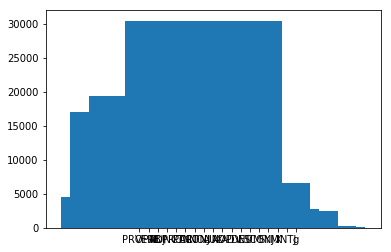

In [19]:
%matplotlib inline
plt.bar(list(latvian_train_tag_distribution.keys()), latvian_train_tag_distribution.values(), 'g', align='center')


In [20]:
latvian_test_tag_distribution

{'SCONJ': 429,
 'PART': 578,
 'PRON': 1100,
 'VERB': 2970,
 'ADJ': 1014,
 'NOUN': 4963,
 'CCONJ': 748,
 'DET': 512,
 'PUNCT': 3837,
 'AUX': 494,
 'NUM': 195,
 'ADP': 833,
 'ADV': 1140,
 'PROPN': 658,
 'X': 122,
 'INTJ': 63,
 'SYM': 53}

<BarContainer object of 17 artists>

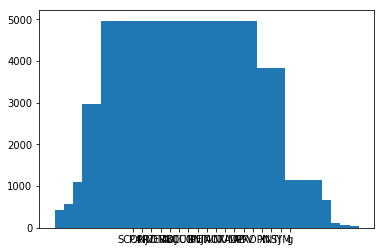

In [21]:
plt.bar(list(latvian_test_tag_distribution.keys()), latvian_test_tag_distribution.values(), 'g', align='center')

#### На графиках в джупитере плохо видно, поэтому выше есть словарь с распределением

In [25]:
MAX_SEQLEN = 211 #максимальная длина предложения
S_MAX_FEATURES = 26702 #количество токенов в исходном словаре/тренировочной выборке
T_MAX_FEATURES = 17 #тэги

In [23]:
latvian_train_unique_words

{'oklendā',
 'runājās',
 'austajā',
 'iesaukts',
 'munters',
 'niecīgo',
 'emocionālu',
 'piemērot',
 'guntis',
 'ikvienā',
 'uzskatus',
 'biljarda',
 'vieglos',
 'nemaksātājus',
 'obligātu',
 'positivus',
 'nespētu',
 'skaidrojusi',
 'šveicē',
 'painless',
 'neredzēt',
 'vispārīgām',
 'griežas',
 'nenostrādā',
 'iemācītos',
 'smukās',
 'noguris',
 'mehānismi',
 'veselīgas',
 'ilgstošas',
 'vienošanās',
 'ārējais',
 'sēžu',
 'hepatīts',
 'grozījumi',
 'izmanto',
 'kriminālsods',
 'cilšu',
 'nomazgāties',
 'sakārtot',
 'ceļgalus',
 'uguņošanas',
 'tiltu',
 'ietekmēja',
 'diženā',
 'speciālas',
 'aktiem',
 'konkurentei',
 'ruupes',
 '•',
 'dubaijā',
 'romantiķim',
 'today',
 'lietai',
 'izvēlas',
 'neatbalsta',
 'rullīšos',
 'uzteica',
 'roni',
 'piekabi',
 'elastību',
 '4000',
 'stiprinošo',
 'mīlētie',
 'depresīvs',
 'attaisu',
 'markas',
 'izteikta',
 'klienti',
 'uzpūšot',
 'rūķīšiem',
 'veidošanu',
 'galvenās',
 'energoietaupījumu',
 'gada',
 'pārsniegšanas',
 'ņukšam',
 'biljardu',

#### Дальше делаем словари соответствия слов и индексов, тэгов и индексов, потому что входные и выходные данные будут последовательностью индексов и нужен будет способ расшифровки

In [26]:
word2index = {w: i + 2 for i,w in enumerate(latvian_train_unique_words)} #ставим токенам в соответсвтие индекс,записываем в словарь
word2index['PAD'] = 0
word2index['UNK'] = 1 #тэг для новых слов
tag2index = {t: i + 1 for i,t in enumerate(latvian_train_tags)}
tag2index['PAD'] = 0

In [27]:
word2index

{'oklendā': 2,
 'runājās': 3,
 'austajā': 4,
 'iesaukts': 5,
 'munters': 6,
 'niecīgo': 7,
 'emocionālu': 8,
 'piemērot': 9,
 'guntis': 10,
 'ikvienā': 11,
 'uzskatus': 12,
 'biljarda': 13,
 'vieglos': 14,
 'nemaksātājus': 15,
 'obligātu': 16,
 'positivus': 17,
 'nespētu': 18,
 'skaidrojusi': 19,
 'šveicē': 20,
 'painless': 21,
 'neredzēt': 22,
 'vispārīgām': 23,
 'griežas': 24,
 'nenostrādā': 25,
 'iemācītos': 26,
 'smukās': 27,
 'noguris': 28,
 'mehānismi': 29,
 'veselīgas': 30,
 'ilgstošas': 31,
 'vienošanās': 32,
 'ārējais': 33,
 'sēžu': 34,
 'hepatīts': 35,
 'grozījumi': 36,
 'izmanto': 37,
 'kriminālsods': 38,
 'cilšu': 39,
 'nomazgāties': 40,
 'sakārtot': 41,
 'ceļgalus': 42,
 'uguņošanas': 43,
 'tiltu': 44,
 'ietekmēja': 45,
 'diženā': 46,
 'speciālas': 47,
 'aktiem': 48,
 'konkurentei': 49,
 'ruupes': 50,
 '•': 51,
 'dubaijā': 52,
 'romantiķim': 53,
 'today': 54,
 'lietai': 55,
 'izvēlas': 56,
 'neatbalsta': 57,
 'rullīšos': 58,
 'uzteica': 59,
 'roni': 60,
 'piekabi': 61,
 'e

In [28]:
S_MAX_FEATURES += 2
T_MAX_FEATURES += 1

#### Подготовка наборов данных на вход сети:

In [29]:
#from tqdm import tqdm_notebook as tqdm 

def build_tensor(latvian_sequences, num_sent, word2index, maxlen):
    data = np.empty((num_sent, ), dtype=list)
    i = 0
    #while data[-2]==None:
    while i < num_sent:
        for sent in latvian_sequences:
            wids = []
            for word in sent:
                if word in word2index:
                    wids.append(word2index[word])
                else:
                    if 'UNK' in word2index:
                        wids.append(word2index['UNK'])

        data[i] = wids         
        i += 1
 
    pdata = sequence.pad_sequences(data, maxlen=maxlen, padding='post', truncating="post")
    return pdata


In [30]:
import time

In [33]:
%time X = build_tensor(latvian_train_sentences, len_train_sent, word2index, MAX_SEQLEN)
%time Y = build_tensor(latvian_train_sentences, len_train_sent, tag2index, MAX_SEQLEN)

%time Xtest = build_tensor(latvian_test_sentences, len_test_sent, word2index, MAX_SEQLEN)
%time Ytest = build_tensor(latvian_test_sentences, len_test_sent, tag2index, MAX_SEQLEN)

#Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, test_size = 0.2, random_state=42)

Wall time: 12min 44s
Wall time: 3min 51s
Wall time: 23 s
Wall time: 10 s


### Simple RNN

In [ ]:
from keras.layers import SimpleRNN

In [ ]:
rnn_model = Sequential()
rnn_model.add(Embedding(S_MAX_FEATURES, 64, input_length=MAX_SEQLEN))
rnn_model.add(SimpleRNN(64, input_shape=(MAX_SEQLEN, S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
rnn_model.add(Dense(T_MAX_FEATURES))
rnn_model.add(Activation("softmax"))

rnn_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
rnn_model.summary()

In [ ]:
# y - correct answers - tags
# h - predictions
def evaluate(y, h, test_tags):
    new_y = []
    new_h = []
    for line in y:
        k = 0
        for i in range(len(test_tags[k])):
            new_y.append(line[i])
        k+=1
    for line in h:
        k = 0
        for i in range(len(test_tags[k])):
            new_h.append(line[i])
        k+=1
    
        
    classes = set(new_y)
    len_new_y = len(new_y)

    results = {'accuracy w/o paddings': 0}
    class_dist = {c: new_y.count(c) / len_new_y for c in classes}

    for c in classes:
        tp = set()
        fp = set()
        tn = set()
        fn = set()

        for i, h_i in enumerate(new_h):
            y_i = new_y[i]
            if h_i == y_i:
                if h_i == c:
                    tp.add((i, h_i))
                else:
                    tn.add((i, h_i))
        acc = len(tp | tn) / len(new_h)

        results['accuracy w/o paddings']  += acc * class_dist[c]
    return results